In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import shape 
import matplotlib.pyplot as plt
import datetime
import sys
sys.path.append('../../Scripts/') # link to scripts
import preprocessing.translate   # import translation scripts from preprocessing

%matplotlib inline

In [2]:
# path to the MTL Trajet data 
path_2016 = "../../Data/mtl_trajet/mtl_trajet_2016.shp"
path_2017 = "../../Data/mtl_trajet/trajets_mtl_trajet_2017.shp"

In [4]:
############## Important ##############
# Note: Script below is used to deal with raw MTL Trajet 2016 data ('trip final') and load into geopandas
# Reason: the data cannot be loaded in because there are invalid geometries

# ## FROM https://gis.stackexchange.com/questions/277231/geopandas-valueerror-a-linearring-must-have-at-least-3-coordinate-tuples
# import json
# import fiona
# path_2016 = "../CASA Projects/msc_dissertation_notebooks/app_route_data/MTL_Trajet_2016_SHP/trip_final/trip_final.shp"
# #Read data
# collection = list(fiona.open(path_2016,'r'))
# df1 = pd.DataFrame(collection)

# #Check Geometry
# def isvalid(geom):
#     try:
#         shape(geom)
#         return 1
#     except:
#         return 0
# df1['isvalid'] = df1['geometry'].apply(lambda x: isvalid(x))
# df1 = df1[df1['isvalid'] == 1]
# collection = json.loads(df1.to_json(orient='records'))

# #Convert to geodataframe
# gdf = gpd.GeoDataFrame.from_features(collection)

## save the file
# gdf.to_file("mtl_trajet/mtl_trajet_2016.shp", encoding='utf-8')
############## Important ##############

### Translate the data

In [3]:
gdf_2016 = preprocessing.translate.dataPreProcessing.translate_data(path_2016).data

In [4]:
gdf_2017 = preprocessing.translate.dataPreProcessing.translate_data(path_2017).data

In [5]:
print(len(gdf_2016.dropna(subset=['mode'])))
print(len(gdf_2016.dropna(subset=['purpose'])))

57879
57879


In [6]:
print(len(gdf_2017.dropna(subset=['mode'])))
print(len(gdf_2017.dropna(subset=['purpose'])))

74218
74218


In [7]:
gdf_2017['purpose'].value_counts()

returning_home      27128
work                19241
leisure              9379
shops                8554
food_drink           3189
education            2830
pick_up_drop_off     1592
other                1219
health               1061
not_available          25
Name: purpose, dtype: int64

In [8]:
gdf_2016['purpose'].value_counts()

returning_home      16187
work                15474
leisure              7552
food_drink           5858
shops                5759
pick_up_drop_off     2521
education            2333
health               2195
Name: purpose, dtype: int64

In [9]:
gdf_2016['mode'].value_counts()

car                      33927
public_transport         12706
walking                   3956
cycling                   3830
public_transport, car     1584
combination               1379
other                      497
Name: mode, dtype: int64

In [10]:
gdf_2017['mode'].value_counts()[:10]

car                               24744
cycling                           13595
public_transport                  12935
walking                           11062
walking, public_transport          6234
public_transport, car               948
car_sharing                         908
walking, cycling                    766
walking, public_transport, car      567
walking, car                        494
Name: mode, dtype: int64

### Remove values not shared between 2016 and 2017

In [11]:
set_2016_md = set(gdf_2016['mode'].unique())
set_2017_md = set(gdf_2017['mode'].unique())

In [12]:
set_2016_pur = set(gdf_2016['purpose'].unique())
set_2017_pur = set(gdf_2017['purpose'].unique())

In [13]:
mode_not_in_2016 = list(set_2017_md.difference(set_2016_md))
purpose_not_in_2016 = list(set_2017_pur.difference(set_2016_pur))
mode_not_in_2017 = list(set_2016_md.difference(set_2017_md))
purpose_not_in_2017 = list(set_2016_pur.difference(set_2017_pur))

In [14]:
# mode values to drop
len(gdf_2017.loc[(gdf_2017['mode'].apply(lambda row: row in mode_not_in_2016))])

10737

In [15]:
# purpose values to drop
len(gdf_2017.loc[(gdf_2017['purpose'].apply(lambda row: row in purpose_not_in_2016))])

1244

In [16]:
purpose_not_in_2017

[]

In [17]:
purpose_not_in_2016

['not_available', 'other']

In [18]:
mode_not_in_2016[:5] + ['...']

['taxi',
 'other, public_transport',
 'walking, car_sharing',
 'car_sharing, other, public_transport',
 'other, cycling',
 '...']

In [19]:
mode_not_in_2017

['combination']

In [20]:
## total trips were multi-mode is chosen
len(np.where(gdf_2017.dropna()['mode'].apply(lambda row: ',' in row))[0])

10256

Text(0.5, 1.0, '2017')

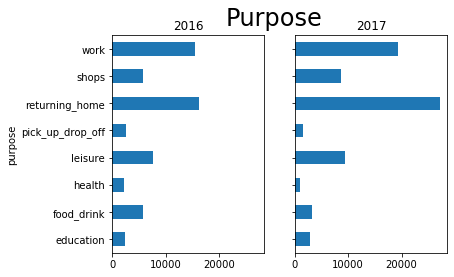

In [21]:
fig, (ax,ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
# plt.subplots_adjust(hspace=2.7)
plt.suptitle("Purpose", size=24)
gdf_2016[gdf_2016['purpose'].apply(lambda row: row in list(set_2017_pur.intersection(set_2016_pur)))].groupby('purpose').agg({'purpose':'count'})['purpose'].plot(kind='barh', ax=ax)
gdf_2017[gdf_2017['purpose'].apply(lambda row: row in list(set_2017_pur.intersection(set_2016_pur)))].groupby('purpose').agg({'purpose':'count'}).plot(kind='barh', ax=ax2, legend=False)
ax.set_title("2016")
ax2.set_title("2017")

Text(0.5, 1.0, '2017')

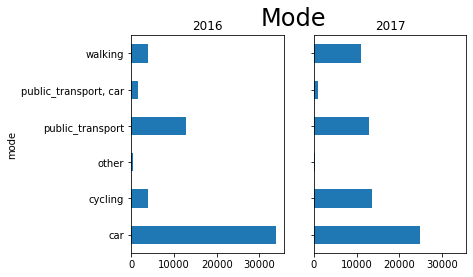

In [22]:
fig, (ax,ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
plt.suptitle("Mode", size=24)
gdf_2016[gdf_2016['mode'].apply(lambda row: row in list(set_2017_md.intersection(set_2016_md)))].groupby('mode').agg({'purpose':'count'})['purpose'].plot(kind='barh', ax=ax)
gdf_2017[gdf_2017['mode'].apply(lambda row: row in list(set_2017_md.intersection(set_2016_md)))].groupby('mode').agg({'purpose':'count'}).plot(kind='barh', ax=ax2, legend=False)
ax.set_title("2016")
ax2.set_title("2017")

## Time zone changes

In [23]:
print("Min:", gdf_2016.starttime.min(), " Max:", gdf_2016.starttime.max())
print("Min:", gdf_2017.starttime.min(), " Max:", gdf_2017.starttime.max())

Min: 2016-09-02T22:46:55-04  Max: 2016-12-14T23:31:37-05
Min: 2017-09-18 04:16:58UTC  Max: 2017-10-18 03:50:08UTC


In [24]:
gdf_2016['starttime'] = pd.to_datetime(gdf_2016['starttime'])
gdf_2016['endtime'] = pd.to_datetime(gdf_2016['endtime'])
gdf_2017['starttime'] = pd.to_datetime(gdf_2017['starttime'])
gdf_2017['endtime'] = pd.to_datetime(gdf_2017['endtime'])

In [25]:
gdf_2016['starttime'].apply(lambda dt: dt.tzinfo).value_counts()
# 2 time zones 

tzoffset(None, -14400)    176346
tzoffset(None, -18000)     99278
Name: starttime, dtype: int64

In [26]:
gdf_2017['starttime'].apply(lambda dt: dt.tzinfo).value_counts()

UTC    185285
Name: starttime, dtype: int64

In [27]:
## replace time zone
gdf_2016['starttime'] = gdf_2016['starttime'].apply(lambda dt: dt.replace(tzinfo=None))
gdf_2016['endtime'] = gdf_2017['starttime'].apply(lambda dt: dt.replace(tzinfo=None))
gdf_2017['starttime'] = gdf_2016['endtime'].apply(lambda dt: dt.replace(tzinfo=None))
gdf_2017['endtime'] = gdf_2017['endtime'].apply(lambda dt: dt.replace(tzinfo=None))

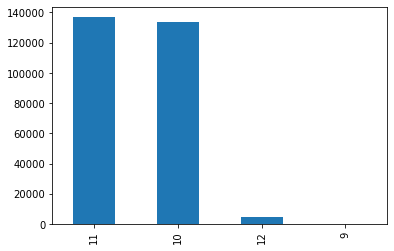

In [28]:
gdf_2016['starttime'].apply(lambda dt: dt.month).value_counts().plot(kind='bar')

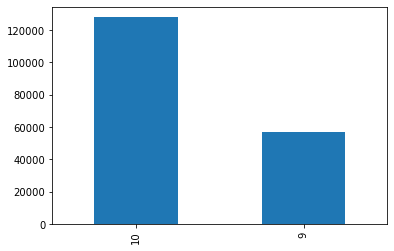

In [29]:
gdf_2017['starttime'].apply(lambda a: a.month).value_counts().plot(kind='bar')

In [30]:
print("Months for 2016:\n", gdf_2016['starttime'].apply(lambda a: a.month).value_counts(), "\n")
print("Months for 2017:\n", gdf_2017['starttime'].apply(lambda a: a.month).value_counts())

Months for 2016:
 11    137037
10    133795
12      4462
9        330
Name: starttime, dtype: int64 

Months for 2017:
 10    128148
9      57137
Name: starttime, dtype: int64


## make subset

In [31]:
## get all values where mode and purpose are in 2016 and 2017 and not None
gdf_2016.loc[(gdf_2016['purpose'].apply(lambda row: row not in list(purpose_not_in_2017)))&
             (gdf_2016['mode'].apply(lambda row: row not in list(mode_not_in_2017)))&
             (gdf_2016['purpose'])&(gdf_2016['mode'])]

,id_trip,avg_speed,duration,mode,purpose,n_coord,segments,starttime,endtime,geometry
0,1724206,4.4,460,walking,returning_home,12,"[{""id"": 1150192, ""source"": ""geobase_mtl""}, {""i...",2016-09-07 20:37:26,2017-09-18 04:16:58,"LINESTRING (-73.5983784907 45.5364060323, -73...."
2,1889461,15.4,447,public_transport,leisure,36,"[{""id"": 1390715, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 19:46:14,2017-09-18 09:30:24,"LINESTRING (-73.55313767040001 45.5261139512, ..."
3,1724219,16.8,591,car,returning_home,45,"[{""id"": 1210250, ""source"": ""geobase_mtl""}, {""i...",2016-09-08 21:41:37,2017-09-18 10:02:50,"LINESTRING (-73.5739219686 45.5336004969, -73...."
5,2071991,12.4,844,cycling,food_drink,56,"[{""id"": 1150004, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 18:22:22,2017-09-18 10:42:13,"LINESTRING (-73.60153864500001 45.537812044, -..."
6,1667922,4.2,1211,cycling,food_drink,29,"[{""id"": 1240379, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 23:41:59,2017-09-18 10:47:52,"LINESTRING (-73.6005503072 45.5240302697, -73...."
7,1667924,3.9,1330,walking,returning_home,29,"[{""id"": 1220168, ""source"": ""geobase_mtl""}, {""i...",2016-09-10 00:10:40,2017-09-18 10:53:49,"LINESTRING (-73.58342384469999 45.5233737253, ..."
8,2071994,9.8,930,cycling,returning_home,49,"[{""id"": 1120087, ""source"": ""geobase_mtl""}, {""i...",2016-09-09 20:04:18,2017-09-18 10:54:50,"LINESTRING (-73.6223175983 45.5362352172, -73...."
9,2072003,4.8,1266,walking,food_drink,34,"[{""id"": 5640, ""source"": ""reseau_cyclable""}, {""...",2016-09-10 10:29:44,2017-09-18 10:57:01,"LINESTRING (-73.599938263 45.5347074582, -73.6..."
10,2072007,4.5,603,walking,leisure,16,"[{""id"": 1240255, ""source"": ""geobase_mtl""}, {""i...",2016-09-10 13:06:26,2017-09-18 11:02:21,"LINESTRING (-73.58864126 45.5175252702, -73.58..."
11,2072009,4.9,529,walking,leisure,15,"[{""id"": 1441, ""source"": ""reseau_cyclable""}, {""...",2016-09-10 14:21:56,2017-09-18 11:02:48,"LINESTRING (-73.5821697122 45.5133917641, -73...."


In [32]:
## get all values where mode and purpose are in 2016 and 2017 and not None
gdf_2017.loc[(gdf_2017['purpose'].apply(lambda row: row not in list(purpose_not_in_2016)))&
             (gdf_2017['mode'].apply(lambda row: row not in list(mode_not_in_2016)))&
             (gdf_2017['purpose'])&(gdf_2017['mode'])]

,id_trip,mode,purpose,starttime,endtime,geometry
3,150744,car,pick_up_drop_off,2017-09-18 10:02:50,2017-09-18 10:17:12,"LINESTRING (-73.646385 45.54629, -73.646064999..."
13,173651,car,work,2017-09-18 11:14:10,2017-09-18 12:01:46,"LINESTRING (-73.81487199999999 45.644683, -73...."
16,149086,public_transport,work,2017-09-18 11:20:42,2017-09-18 12:10:14,"LINESTRING (-73.563513 45.516447, -73.563435 4..."
19,358412,walking,work,2017-09-18 11:27:38,2017-09-18 11:40:26,"LINESTRING (-73.590244 45.53261, -73.590298 45..."
20,350121,car,work,2017-09-18 11:31:56,2017-09-18 12:11:26,(LINESTRING (-73.19817500000001 45.55655900000...
21,35763,car,shops,2017-09-18 11:32:54,2017-09-18 12:04:07,"LINESTRING (-73.473197 45.40843, -73.473086 45..."
22,230363,public_transport,work,2017-09-18 11:33:37,2017-09-18 12:16:09,"(LINESTRING (-73.633802 45.540946, -73.633589 ..."
24,223745,walking,work,2017-09-18 11:36:48,2017-09-18 11:42:12,"LINESTRING (-73.609131 45.540172, -73.60917000..."
25,17106,cycling,work,2017-09-18 11:44:21,2017-09-18 12:27:02,"(LINESTRING (-73.52567500000001 45.599876, -73..."
26,321720,car,work,2017-09-18 11:45:19,2017-09-18 12:17:40,"LINESTRING (-73.574883 45.548081, -73.574714 4..."


In [33]:
gdf_2016.set_index('starttime').index#.groupby(pd.Grouper(freq='1m')).count()

DatetimeIndex(['2016-09-07 20:37:26', '2016-09-08 07:43:23',
               '2016-09-08 19:46:14', '2016-09-08 21:41:37',
               '2016-09-09 16:49:12', '2016-09-09 18:22:22',
               '2016-09-09 23:41:59', '2016-09-10 00:10:40',
               '2016-09-09 20:04:18', '2016-09-10 10:29:44',
               ...
               '2016-10-30 20:52:36', '2016-10-31 07:36:32',
               '2016-11-07 16:26:58', '2016-10-25 07:05:48',
               '2016-10-25 07:04:30', '2016-10-19 08:54:39',
               '2016-11-02 12:25:27', '2016-11-07 06:18:17',
               '2016-10-20 10:46:38', '2016-11-03 07:32:44'],
              dtype='datetime64[ns]', name='starttime', length=275624, freq=None)

In [34]:
gdf_2016.starttime.min(),gdf_2016.starttime.max()

(Timestamp('2016-09-02 22:46:55'), Timestamp('2016-12-14 23:31:37'))

In [35]:
gdf_2017.starttime.min(),gdf_2017.starttime.max()

(Timestamp('2017-09-18 04:16:58'), Timestamp('2017-10-18 03:50:08'))